In [5]:
import networkx as nx
import numpy as np
from scipy.special import binom
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.metrics import normalized_mutual_info_score
from tqdm import tqdm
import multiprocessing
from time import time
import pickle
from pprint import pprint

from methods import *

np.random.seed(1234)

## About sampling

In [48]:
networks = [
    nx.karate_club_graph().to_undirected(),
    nx.florentine_families_graph().to_undirected(),
    nx.read_gml("dolphins.gml").to_undirected()
]

labels = [
    "Karate Club",
    "Florentine Families",
    "Dolphins"
]

colors = sns.color_palette("husl", len(networks))

In [ ]:
# Transient and NMI
max_iter_transient = 5000
max_iter_nmi = 5001

transient = np.zeros((len(networks), max_iter_transient+1))
nmi = np.zeros((len(networks), max_iter_nmi))

for i, G in enumerate(networks):
    # Create the adjacency matrix
    A = nx.adjacency_matrix(G).todense()
    A = (A > 0).astype(int)
    N = A.shape[0]

    # Groups data structure: list of lists
    groups = [[] for _ in range(N)]

    # Uniformly random initialization
    for j in range(N): 
        g = np.random.randint(0, N)
        groups[g].append(j)

    # Transient time (to test convergence)
    H = hamiltonian(A, groups)
    transient[i, 0] = H
    for k in tqdm(range(max_iter_transient)):
        groups, H = singleStep(groups, H, A)
        transient[i, k+1] = H

    # NMI
    belongs_to = arrayGroups(groups)
    for k in tqdm(range(max_iter_nmi)):
        groups, H = singleStep(groups, H, A)
        nmi[i, k] = normalized_mutual_info_score(belongs_to, arrayGroups(groups))

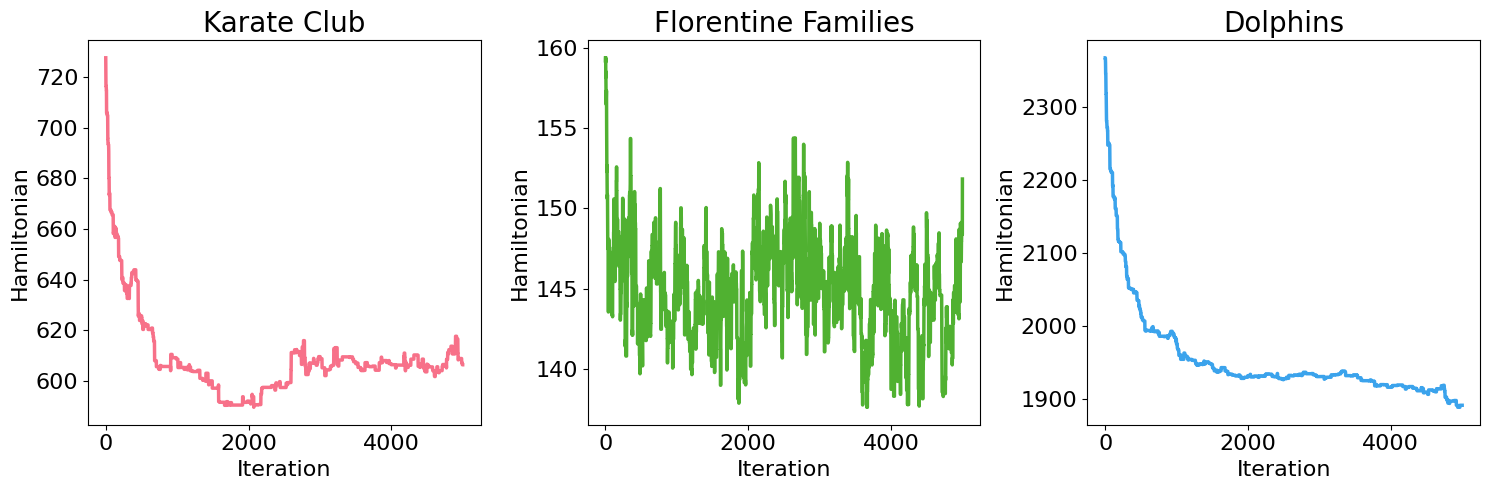

In [60]:
fontsize_label = 16
fontsize_title = 20

x = np.arange(max_iter_transient+1)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(len(networks)):
    ax[i].plot(x, transient[i], color=colors[i], linewidth=2.5)
    ax[i].set_title(f"{labels[i]}", fontsize=fontsize_title)
    ax[i].set_xlabel("Iteration", fontsize=fontsize_label)
    ax[i].set_ylabel("Hamiltonian", fontsize=fontsize_label)
    ax[i].tick_params(axis='both', which='major', labelsize=fontsize_label)
    ax[i].tick_params(axis='both', which='minor', labelsize=fontsize_label)
    #ax[i].grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

#fig.suptitle("Transient time", fontsize=1.5*fontsize_title)
plt.tight_layout()

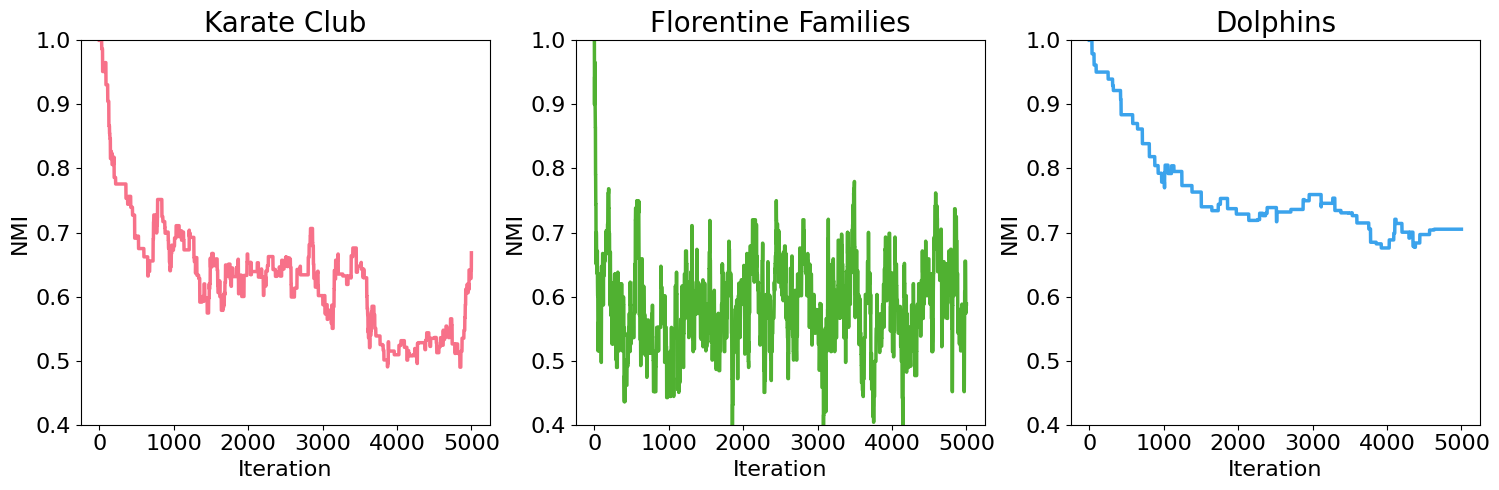

In [61]:
fontsize_label = 16
fontsize_title = 20

x = np.arange(max_iter_nmi)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(len(networks)):
    ax[i].plot(x, nmi[i], color=colors[i], linewidth=2.5)
    ax[i].set_title(f"{labels[i]}", fontsize=fontsize_title)
    ax[i].set_xlabel("Iteration", fontsize=fontsize_label)
    ax[i].set_ylabel("NMI", fontsize=fontsize_label)
    ax[i].tick_params(axis='both', which='major', labelsize=fontsize_label)
    ax[i].tick_params(axis='both', which='minor', labelsize=fontsize_label)
    ax[i].set_ylim([0.4, 1])
    #ax[i].grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

#fig.suptitle("NMI", fontsize=1.5*fontsize_title)
plt.tight_layout()

## Visual

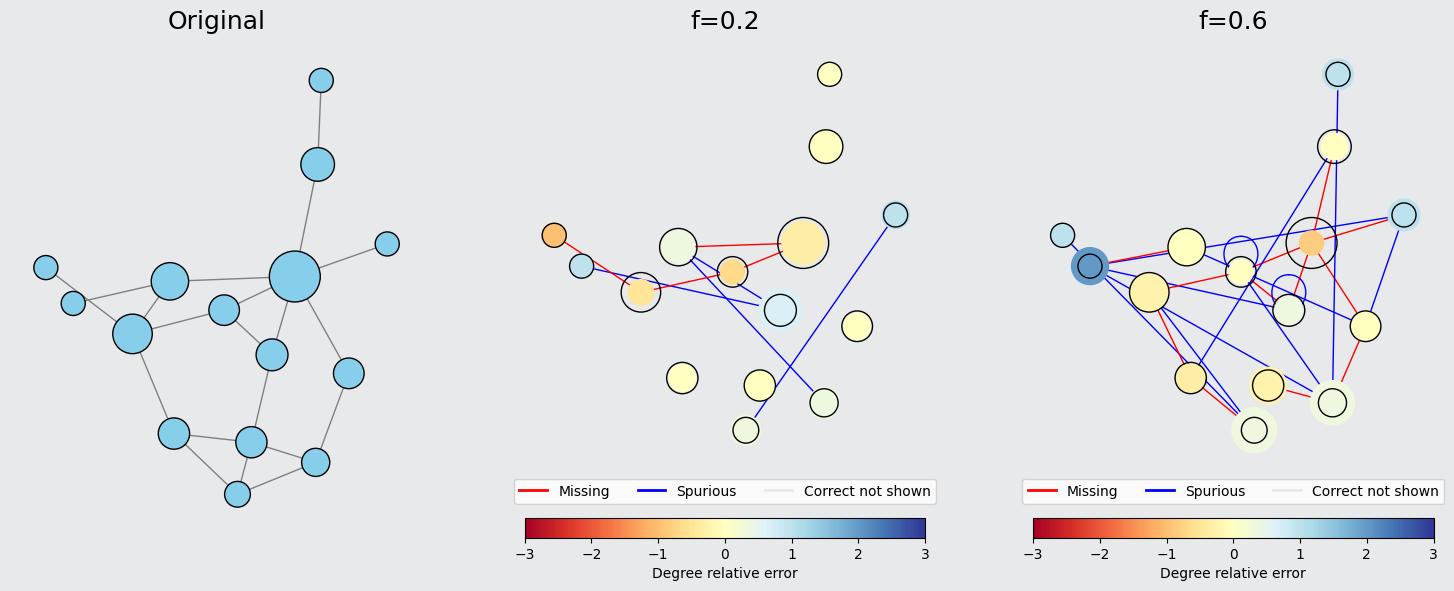

In [4]:
G = nx.florentine_families_graph().to_undirected()
A = nx.adjacency_matrix(G).todense()
A = (A > 0).astype(int)

A_1 = corruptAdjacencyMatrix(A, p=0.2, mode='both')
A_2 = corruptAdjacencyMatrix(A, p=0.6, mode='both')

fig, ax = plotGraphsComparison(A, A_1, A_2, 
                               titles=["Original", "f=0.2", "f=0.6"], fontsize=18)
fig.show()

## From logs

### Reliability scan

In [7]:
p_vec_net = np.arange(0.05, 0.55, 0.05)

In [9]:
networks = [
    "karate_club", 
    "florentine_families",
    "dolphins"
]

p_vec_link = np.arange(0.05, 1, 0.05)

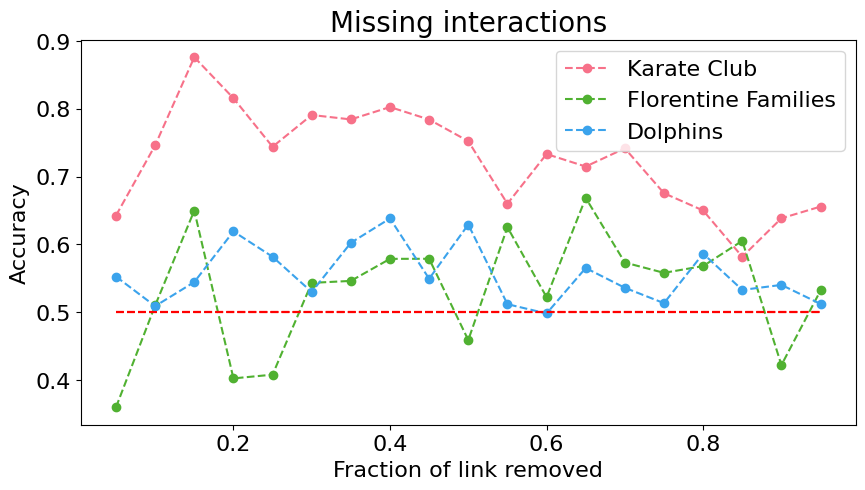

In [14]:
# Missing interactions
fontsize_label = 16
fontsize_title = 20

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for i, net in enumerate(networks):
    with open(f"./logs/scan_{net}.pkl", "rb") as file:
        results = pickle.load(file)

    ax.plot(p_vec_link, results["missing"], 'o--', label=labels[i], color=colors[i])
    ax.hlines(0.5, p_vec_link[0], p_vec_link[-1], color='red', linestyle='--')

    ax.set_xlabel("Fraction of link removed", fontsize=fontsize_label)
    ax.set_ylabel("Accuracy", fontsize=fontsize_label)
    ax.set_title("Missing interactions", fontsize=fontsize_title)

    ax.tick_params(axis='both', which='major', labelsize=fontsize_label)
    ax.tick_params(axis='both', which='minor', labelsize=fontsize_label)

    ax.legend(fontsize=fontsize_label)
    

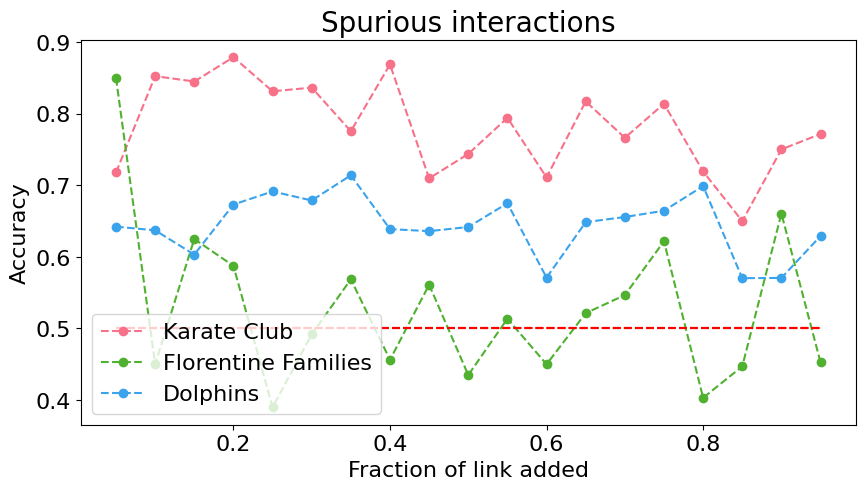

In [15]:
# Spurious interactions
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for i, net in enumerate(networks):
    with open(f"./logs/scan_{net}.pkl", "rb") as file:
        results = pickle.load(file)

    ax.plot(p_vec_link, results["spurious"], 'o--', label=labels[i], color=colors[i])
    ax.hlines(0.5, p_vec_link[0], p_vec_link[-1], color='red', linestyle='--')

    ax.set_xlabel("Fraction of link added", fontsize=fontsize_label)
    ax.set_ylabel("Accuracy", fontsize=fontsize_label)
    ax.set_title("Spurious interactions", fontsize=fontsize_title)

    ax.tick_params(axis='both', which='major', labelsize=fontsize_label)
    ax.tick_params(axis='both', which='minor', labelsize=fontsize_label)

    ax.legend(fontsize=fontsize_label)

Text(0, 0.5, '$\\log_{10}(R^N_A / R^N_{A^O}$)')

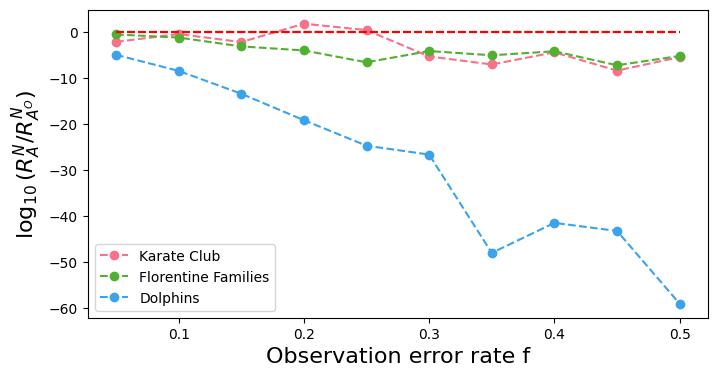

In [81]:
networks = ["karate_club", "florentine_families", "dolphins"]
p_vec_net = np.arange(0.05, 0.55, 0.05)

fontsize_label = 16

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
for i, net in enumerate(networks):
    with open(f"./logs/scan_{net}.pkl", "rb") as file:
        results = pickle.load(file)

    ax.plot(p_vec_net, results["network"], 'o--', label=labels[i], color=colors[i])
    ax.hlines(0, p_vec_net[0], p_vec_net[-1], color='red', linestyle='--') 

    ax.legend()

ax.set_xlabel("Observation error rate f", fontsize=fontsize_label)
ax.set_ylabel(r"$\log_{10}(R^N_A / R^N_{A^O}$)", fontsize=fontsize_label)

Text(0.1, 6, 'Karate Club')

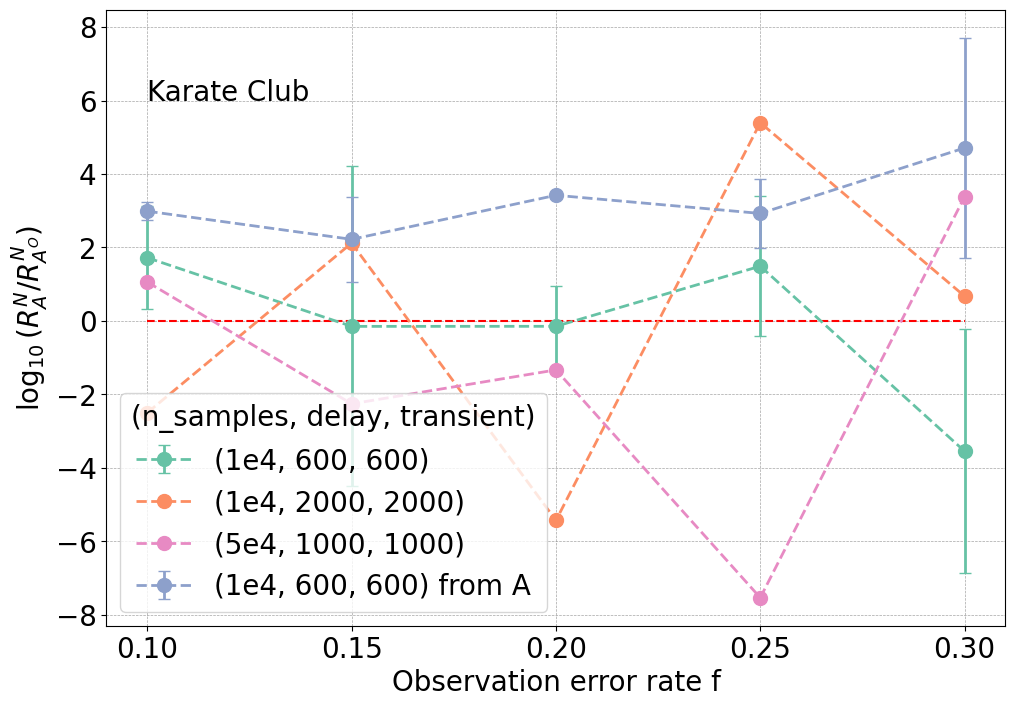

In [46]:
# Desperate attempt
scan = np.array([ [ 3.22043108,  5.83481127,  1.2915125 ,  4.25808993, -6.38991841],                  
                  [ 3.63926915,  4.09756081, -0.45921194,  0.30160265, -0.92722134],
                  [ 0.53259356, -4.08101588,  0.54310834,  2.8113945,  -7.92544822],
                  [ 0.43148024 ,-1.60019389, -0.13779021,  1.25830435, -3.52923507],
                  [ 0.77369141, -5.00016792, -1.97777909, -1.18224928,  1.02564264]])
long_tau = np.array([-2.50066466,  2.11818344, -5.4337532,   5.39521885,  0.67219107])
A_sampling = np.array([[2.74176634, 1.0560417,  3.39933052,  1.983899,   1.70685716],
                       [3.23017679,  3.38347088, 3.44019218, 3.86651744, 7.7094702 ]])
more_samples = np.array([ 1.05752148, -2.25888696, -1.33508059, -7.53790074,  3.37797909])

fontsize_label = 20
fontsize_title = 20
colors = sns.color_palette("Set2", 4)

p_list = [0.1, 0.15, 0.20, 0.25, 0.30]
fig, ax = plt.subplots(1, 1, figsize=(8*1.45, 8))
ax.hlines(0, p_list[0], p_list[-1], color='red', linestyle='--')

ax.errorbar(p_list, np.mean(scan, axis=0), yerr=np.std(scan, axis=0), fmt='o--', capsize=4, color=colors[0], label="(1e4, 600, 600)", markersize=10, linewidth=2)
ax.errorbar(p_list, long_tau, fmt='o--', capsize=4, color=colors[1], label="(1e4, 2000, 2000)", markersize=10, linewidth=2)
ax.errorbar(p_list, more_samples, fmt='o--', capsize=4, color=colors[3], label="(5e4, 1000, 1000)", markersize=10, linewidth=2)
ax.errorbar(p_list, np.mean(A_sampling, axis=0), yerr=np.std(A_sampling, axis=0), fmt='o--', capsize=4, color=colors[2], label="(1e4, 600, 600) from A", markersize=10, linewidth=2)

ax.set_xlabel("Observation error rate f", fontsize=fontsize_label)
ax.set_ylabel(r"$\log_{10}(R^N_A / R^N_{A^O}$)", fontsize=fontsize_label)
#ax.set_title("Preliminary study on network reconstruction", fontsize=fontsize_title)

ax.legend(fontsize=fontsize_label, loc = "lower left",
          title="(n_samples, delay, transient)", title_fontsize=fontsize_label)
ax.set_xticks(p_list)
ax.tick_params(axis='both', which='major', labelsize=fontsize_label)
ax.tick_params(axis='both', which='minor', labelsize=fontsize_label)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
ax.text(0.1, 6, "Karate Club", fontsize=fontsize_label)

### Network reconstruction

In [ ]:
with open("./logs/netRec_karate_club.pkl", "rb") as file:
    results = pickle.load(file)

pprint(results)

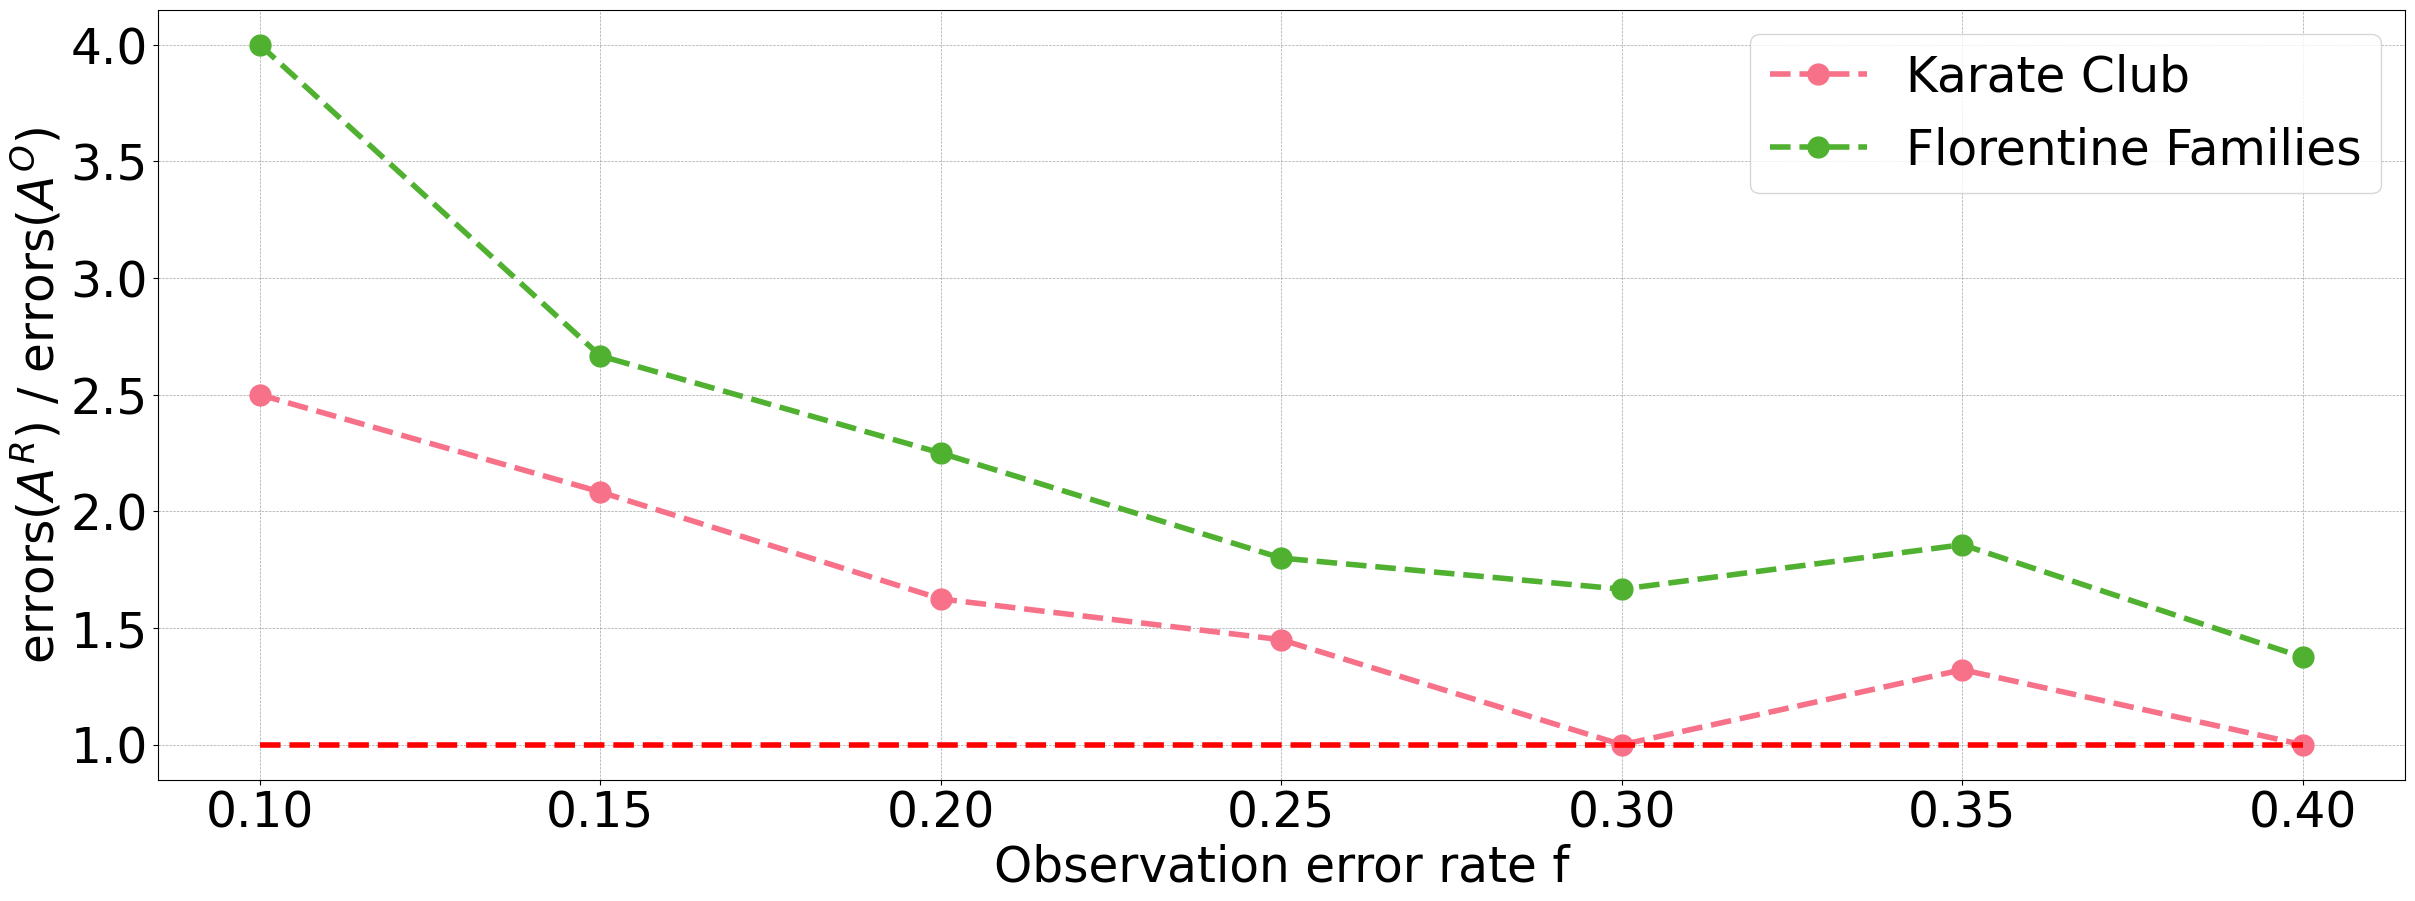

In [61]:
networks = ["karate_club", "florentine_families"]
fontsize_label = 35

fig, ax = plt.subplots(1, 1, figsize=(29, 10))

for i, net in enumerate(networks):
    with open(f"./logs/netRec_{net}.pkl", "rb") as file:
        results = pickle.load(file)

    p_list = results["p-list"]
    score = np.zeros(len(p_list))
    for j, p in enumerate(p_list):
        score[j] = results[p]["errors_recon"]/results[p]["errors_obs"]

    ax.plot(p_list, score, 'o--', label=labels[i], color=colors[i], linewidth=4, markersize=15)

ax.hlines(1, p_list[0], p_list[-1], color='red', linestyle='--', linewidth=4)
ax.legend(fontsize=fontsize_label)

ax.set_xlabel("Observation error rate f", fontsize=fontsize_label)
ax.set_ylabel(r"errors($A^R$) / errors($A^O$)", fontsize=fontsize_label)

ax.tick_params(axis='both', which='major', labelsize=fontsize_label)
ax.tick_params(axis='both', which='minor', labelsize=fontsize_label)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

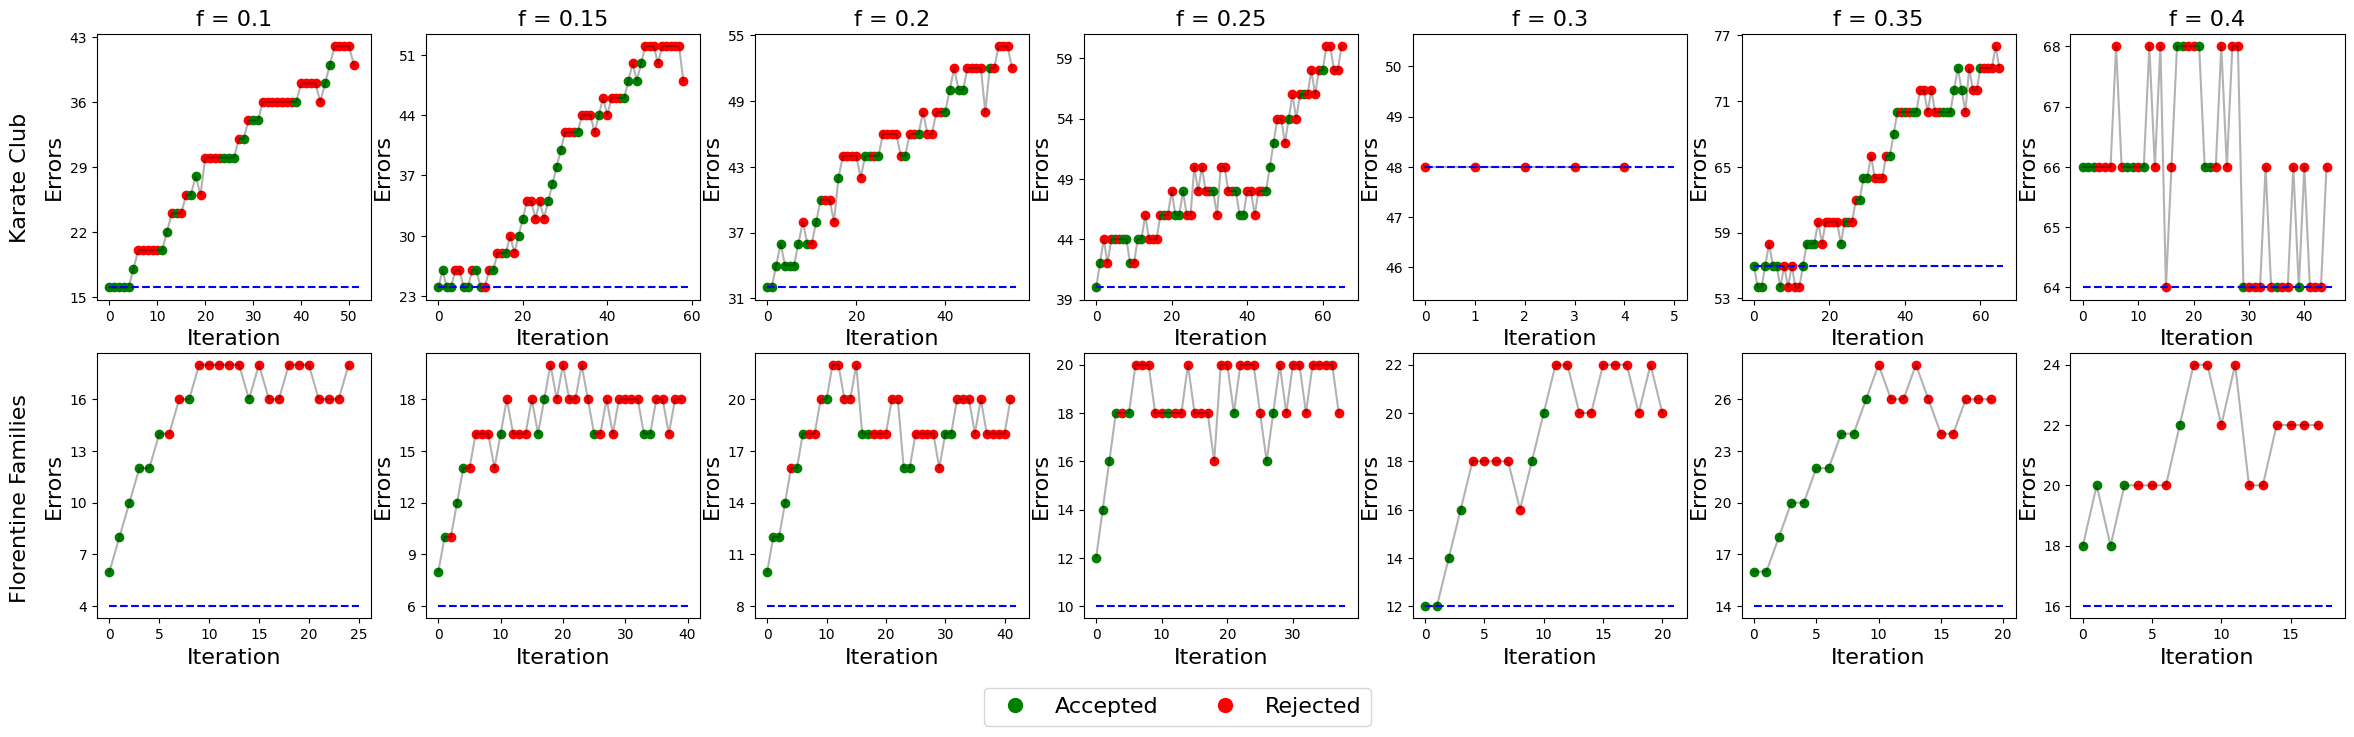

In [79]:
import matplotlib.lines as mlines

fontsize_label = 16
fig, ax = plt.subplots(len(networks), len(p_list), figsize=(29, 8))

for i, net in enumerate(networks):
    with open(f"./logs/netRec_{net}.pkl", "rb") as file:
        results = pickle.load(file)

    for j, p in enumerate(p_list):
        proposed = results[p]["hist_proposed"]
        accepted = results[p]["hist_accepted"]
        init = results[p]["errors_obs"]

        # Create the colormap based on the 'accepted' array
        colormap = np.where(np.array(accepted) == 1, 'green', 'red')
        
        # Plot each point with the corresponding color
        for k in range(len(proposed)):
            ax[i, j].plot(k, proposed[k], marker='o', color=colormap[k])

        ax[i, j].plot(proposed, color='black', alpha=0.3)
        ax[i, j].hlines(init, 0, len(proposed), color='blue', linestyle='--')
        
        ax[i, j].set_ylabel("Errors", fontsize=fontsize_label)
        ax[i, j].set_xlabel("Iteration", fontsize=fontsize_label)

        ax[0, j].set_title(f"f = {p}", fontsize=fontsize_label)

        # Remove ticks and labels
        #ax[i, j].set_xticks([])
        #ax[i, j].set_yticks([])

        ymin, ymax = ax[i, j].get_ylim()
        step = max(1, int((ymax - ymin) / 4))
        ax[i, j].set_yticks(np.arange(np.ceil(ymin), np.floor(ymax) + 1, step))
        
    
    #ax[i, 0].set_ylabel(labels[i], fontsize=fontsize_label)

for i in range(len(networks)):
    fig.text(0.095, 0.7 - 0.8*(i / len(networks)), labels[i], va='center', rotation='vertical', fontsize=fontsize_label)

# Create custom legend using Line2D objects
accepted_handle = mlines.Line2D([], [], color='green', marker='o', linestyle='None', markersize=10, label='Accepted')
rejected_handle = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=10, label='Rejected')

# Add the legend below the grid of subplots
fig.legend(handles=[accepted_handle, rejected_handle], loc='lower center', fontsize=fontsize_label, ncol=2)

# Adjust layout to make space for the legend
plt.subplots_adjust(bottom=0.15)

#fig.tight_layout()